<a href="https://www.kaggle.com/code/brianvilnrotter/panic-attack-dataset?scriptVersionId=218353129" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/panic-attack-dataset/panic_attack_dataset.csv


# Table of Contents

* [0. Data Collection & Feature Definitions](#chapter0)
    * [0.1 Initial Descriptions and Metrics of Data](#chapter0_1)
    * [0.2 Initials Observations of Features](#chapter0_2)
* [1. Initial Predictions & Model Testing](#chapter1)
    * [1.1 Initial Lists for Features](#chapter1_1)
    * [1.2 Build out Initial Functions to Fit and Score Models](#chapter1_2)
* [2. Troubleshoot Poor Results](#chapter2)
* [3. Insights from Data](#chapter3)

## 0. Data Collection & Feature Definitions <a class="anchor" id="chapter0"></a>

In [2]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold

np.random.seed(42)

### 0.1 Initial Descriptions and Metrics of Data <a class="anchor" id="chapter0_1"></a>

|Column|Desfinition|
|:----------|:-----------|
|ID | Unique identifier|
|Age | Age of the individual
|Gender | Male, Female, Non-binary
|Panic_Attack_Frequency | Number of panic attacks per month
|Duration_Minutes | Average duration of panic attack (minutes)
|Trigger | Main trigger (e.g., stress, social anxiety, phobia, PTSD, caffeine, unknown)
|Heart_Rate | Heart rate during a panic attack (bpm)
|Sweating | Yes/No
|Shortness_of_Breath | Yes/No
|Dizziness | Yes/No
|Chest_Pain | Yes/No
|Trembling | Yes/No
|Medical_History | Pre-existing conditions (e.g., Anxiety, Depression, PTSD)
|Medication | Taking medication for anxiety (Yes/No)
|Caffeine_Intake | Cups of coffee/tea per day
|Exercise_Frequency | Days of exercise per week
|Sleep_Hours | Average sleep hours per night
|Alcohol_Consumption | Drinks per week
|Smoking | Smoker (Yes/No)
|Therapy | Attending therapy (Yes/No)
|Panic_Score | Severity score (1-10)

In [3]:
df = pd.read_csv('/kaggle/input/panic-attack-dataset/panic_attack_dataset.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,1200.0,600.500000,346.554469,1.0,300.75,600.5,900.25,1200.0
Age,1200.0,41.134167,13.543412,18.0,29.00,42.0,53.00,64.0
Panic_Attack_Frequency,1200.0,4.412500,2.847648,0.0,2.00,4.0,7.00,9.0
Duration_Minutes,1200.0,24.392500,11.399930,5.0,15.00,24.0,34.00,44.0
Heart_Rate,1200.0,120.302500,23.369912,80.0,100.00,121.0,141.00,159.0
Caffeine_Intake,1200.0,2.539167,1.716854,0.0,1.00,3.0,4.00,5.0
Exercise_Frequency,1200.0,2.955000,2.061516,0.0,1.00,3.0,5.00,6.0
Sleep_Hours,1200.0,6.481583,1.405625,4.0,5.30,6.5,7.60,9.0
Alcohol_Consumption,1200.0,4.416667,2.902598,0.0,2.00,4.0,7.00,9.0
Panic_Score,1200.0,5.569167,2.793155,1.0,3.00,6.0,8.00,10.0


The above information is good, but we should make a comparison table to get better information out of the dataframe (better than df.info())

In [4]:
def get_inferred_type(column):
    if pd.api.types.is_object_dtype(column):
        sample_value = column.dropna().iloc[0]
        return type(sample_value).__name__
    else:
        return column.dtype

def comparison_table(df):
    return pd.DataFrame({
        'Data Types':df.apply(get_inferred_type),
        'Missing Values':df.isna().sum(),

        'Unique Values':df.nunique()
    })


comp_table = comparison_table(df) # the variable that will be used later

with pd.option_context('display.max_rows',None,'display.max_columns',None):
    print(comp_table)

                       Data Types  Missing Values  Unique Values
ID                          int64               0           1200
Age                         int64               0             47
Gender                        str               0              3
Panic_Attack_Frequency      int64               0             10
Duration_Minutes            int64               0             40
Trigger                       str               0              6
Heart_Rate                  int64               0             80
Sweating                      str               0              2
Shortness_of_Breath           str               0              2
Dizziness                     str               0              2
Chest_Pain                    str               0              2
Trembling                     str               0              2
Medical_History               str             122              3
Medication                    str               0              2
Caffeine_Intake          

the important consideration from the above code shows that the only feature that has missing values is `Medical_History`. Since these are string values, it would be beneficial to put a specific value to the null values (especially since there are only 3 unique values)

In [5]:
df['Medical_History'] = df['Medical_History'].fillna('None').astype(str)

### 0.2 Initial Observations of Features <a class="anchor" id="chapter0_2"></a>

<Axes: >

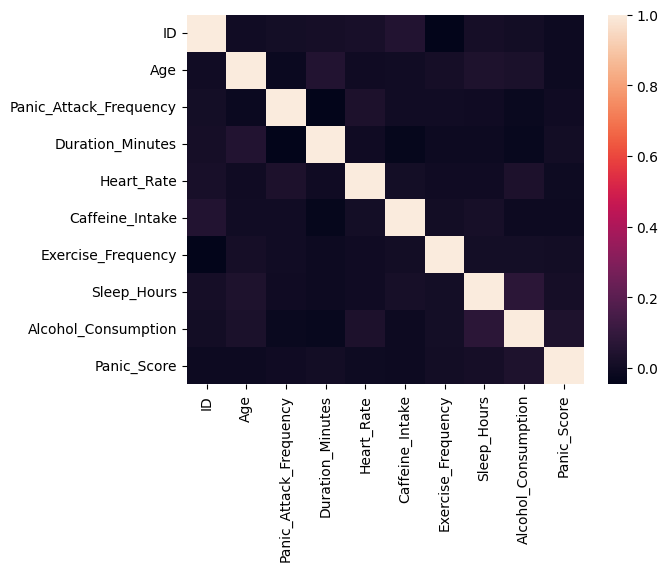

In [6]:
sns.heatmap(df.corr(numeric_only=True))

The above shows no good correlational patterns between the numeric features and labels. The next step would be to see if there are any good patterns within the data for categorical features compared to the label ("Panic_Score")

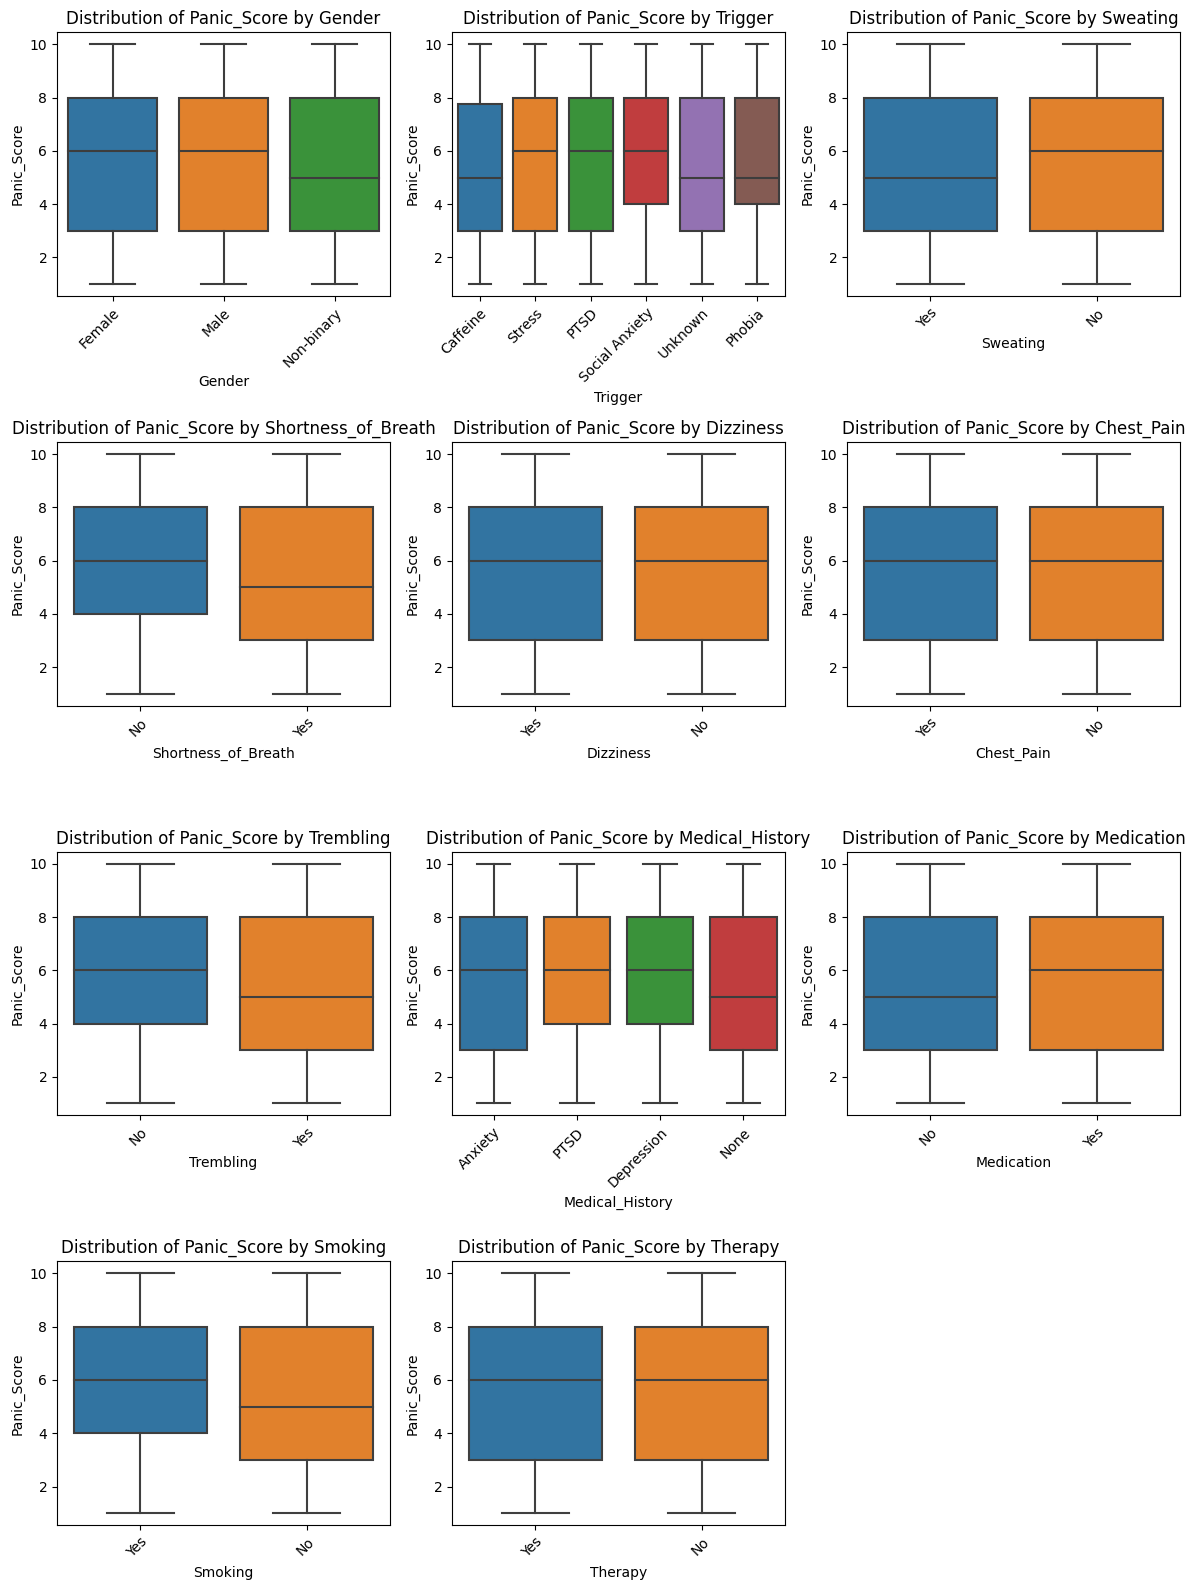

In [7]:
categorical_features = df.select_dtypes(include=['object']).columns
cols = 3
rows = math.ceil(len(categorical_features)/cols)

fig,axes = plt.subplots(rows,cols,figsize=(12,rows*4))
axes = axes.flatten()

for i,feature in enumerate(categorical_features):
    sns.boxplot(x=df[feature],y=df['Panic_Score'],ax=axes[i])
    axes[i].set_title(f"Distribution of Panic_Score by {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Panic_Score')
    axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation=45,ha='right',wrap=True)

for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Due to the boxplots of categorical features, and correlation value in numerical features it does not appear like the data has very strong direct or indirect proportionality to the label (Panic_Score). We will try different scikit learn models to see if any strong patterns come from those learning methods.

In [8]:
categorical_columns = df.select_dtypes(include=['object']).columns
# manually encode categorical features
df_encoded = pd.get_dummies(
    df,columns=categorical_columns,prefix=categorical_columns,drop_first=True)
# the selector will help navigate features that have a low variance in their data
selector = VarianceThreshold(threshold=.09)
reduced = selector.fit_transform(df_encoded)

low_variance_features = [
    col for col,support in zip(df_encoded.columns,selector.get_support()) if not support]
print(f"Selected features with low variance: {low_variance_features}")

df_encoded = df_encoded.drop(columns=low_variance_features,axis=1)
comp_table = comparison_table(df_encoded)
print(comp_table)

Selected features with low variance: ['Gender_Non-binary']
                           Data Types  Missing Values  Unique Values
ID                              int64               0           1200
Age                             int64               0             47
Panic_Attack_Frequency          int64               0             10
Duration_Minutes                int64               0             40
Heart_Rate                      int64               0             80
Caffeine_Intake                 int64               0              6
Exercise_Frequency              int64               0              7
Sleep_Hours                   float64               0             51
Alcohol_Consumption             int64               0             10
Panic_Score                     int64               0             10
Gender_Male                      bool               0              2
Trigger_PTSD                     bool               0              2
Trigger_Phobia                   bool       

The above was added post-mortem as a test to see if there were any low variance features that could be removed to enhance the results of the below models. The threshold value can be adjusted to see if dropping more features would improve predictability of the data. Its important to note that this method dynamically alters the data such that the categorical features are manually encoded, and then specific features are dropped if variance is too low. This muddles with the data in ways that may not be beneficial as a whole, and as is shown in the below model tests it actually reduces accuracy % of the classifiers, and does not make progress in making the accuracy MSE values of the regressor models >0

## 1. Initial Predictions & Model Testing <a class="anchor" id="chapter1"></a>

In [9]:
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.linear_model import SGDRegressor,SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer,PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway,pearsonr

### 1.1 Build Initial Lists for Features <a class="anchor" id="chapter1_1"></a>

In [10]:
# build a features dictionary containing a list of numeric and categorical features
numerical_features = []
categorical_features = []
boolean_features = []

for feature in comp_table.index:
    if feature != 'Panic_Score' and feature != 'ID':
        row = comp_table.loc[feature]
        if row["Data Types"] in ['str']:
            categorical_features.append(feature)
        elif row['Data Types'] in ['int64','float64']:
            numerical_features.append(feature)
        elif row['Data Types'] in ['bool']:
            boolean_features.append(feature)

features = {
    'Numerical Features':numerical_features,
    'Categorical Features':categorical_features,
    'Boolean Features':boolean_features
}

features

{'Numerical Features': ['Age',
  'Panic_Attack_Frequency',
  'Duration_Minutes',
  'Heart_Rate',
  'Caffeine_Intake',
  'Exercise_Frequency',
  'Sleep_Hours',
  'Alcohol_Consumption'],
 'Categorical Features': [],
 'Boolean Features': ['Gender_Male',
  'Trigger_PTSD',
  'Trigger_Phobia',
  'Trigger_Social Anxiety',
  'Trigger_Stress',
  'Trigger_Unknown',
  'Sweating_Yes',
  'Shortness_of_Breath_Yes',
  'Dizziness_Yes',
  'Chest_Pain_Yes',
  'Trembling_Yes',
  'Medical_History_Depression',
  'Medical_History_None',
  'Medical_History_PTSD',
  'Medication_Yes',
  'Smoking_Yes',
  'Therapy_Yes']}

### 1.2 Build out Initial Functions to Fit and Score Models <a class="anchor" id="chapter1_2"></a>

In [11]:
# make the pipeline function that will be used later to organize and score \
# the different sklearn models to use with the data
def make_pipeline(features,model_object):
    preprocessor = ColumnTransformer(transformers=[
        ('num',Pipeline([
            ('imputer',SimpleImputer(strategy='mean')),
            ('scaler',StandardScaler())
        ]),features['Numerical Features']),
        ('cat',Pipeline([
            ('imputer',SimpleImputer(strategy='most_frequent')),
            ('onehot',OneHotEncoder(drop='first',handle_unknown='ignore'))
        ]),features['Categorical Features']),
        ('bool',Pipeline([
            ('to_numeric',FunctionTransformer(lambda x:x.astype(float))),
            ('imputer',SimpleImputer(strategy='most_frequent'))
        ]),features['Boolean Features'])
    ])
    return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('estimator',model_object)
    ])

In [12]:
abacuss = {
    'RandomForestRegressor_page':{
        'model':RandomForestRegressor(random_state=42)
    },
    'SGDRegressor_page':{
        'model':SGDRegressor(random_state=42)
    },
    'XGBRegressor_page':{
        'model':XGBRegressor(random_state=42)
    },
    'GadientBoostingRegressor':{
        'model':GradientBoostingRegressor(random_state=42)
    },
    'RandomForestCalssifier_page':{
        'model':RandomForestClassifier(random_state=42)
    },
    'SGDClassifier_page':{
        'model':SGDClassifier(random_state=42)
    },
    'XGBClassifier_page':{
        'model':GradientBoostingClassifier(random_state=42)
    }
}

abacuss

{'RandomForestRegressor_page': {'model': RandomForestRegressor(random_state=42)},
 'SGDRegressor_page': {'model': SGDRegressor(random_state=42)},
 'XGBRegressor_page': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...)},
 'GadientBoostingRegressor': {'model': GradientBoosting

In [13]:
# split the label column from the rest of the data
X = df_encoded.drop('Panic_Score',axis=1)
y = df_encoded['Panic_Score']

In [14]:
X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.3)
X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,test_size=0.5)

(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

((840, 26), (180, 26), (180, 26), (840,), (180,), (180,))

In [15]:
model_scores = {}

def update_model_scores(
    pipeline,
    X_train,
    X_val,
    model_tag,
    model_scores=model_scores,
    tuned_tag='baseline'
):
    preds = pipeline.predict(X_val)
    model_scores.update({
        f'{model_tag} {tuned_tag}':{
            'accuracy':pipeline.score(X_val,y_val),
            'MSE':mean_squared_error(y_val,preds),
            'pipeline':pipeline
        }
    })
    return model_scores

In [16]:
for page in abacuss:
    pipeline = make_pipeline(features,abacuss[page]['model'])
    pipeline.fit(X_train,y_train)
    model_scores = update_model_scores(pipeline,X_train,X_val,page)

<Axes: >

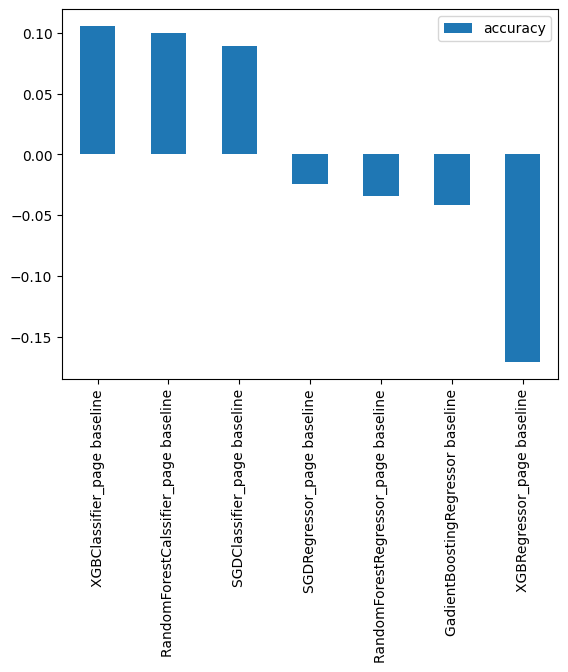

In [17]:
model_compare = pd.DataFrame(model_scores,index=['accuracy'])
model_compare.T.sort_values('accuracy',ascending=False).plot.bar()

The above are pretty dismal results, and are likely due to the low correlation power between the data provided. With little to no patterns being found against the label (Panic_Score). Despite the regressors and classifiers are mapped on the same bar chart while using `.score()` function (which is not advisable to do) the values between regressor results and classifier results should be interpretted differently.

That said, with MSE scores (regressor `.score()` values) return <0 values we can determine that less predicted values were accurate than the mean (it's worse than just flipping a coin). Further, with the accuracy scores (classifier `.score()` values) the results show that at baseline our models are returning accuracy at most 10% accurate.

## 2. Troubleshoot Poor Results <a class="anchor" id="chapter2"></a>

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_classif,mutual_info_regression
from sklearn.metrics import silhouette_score

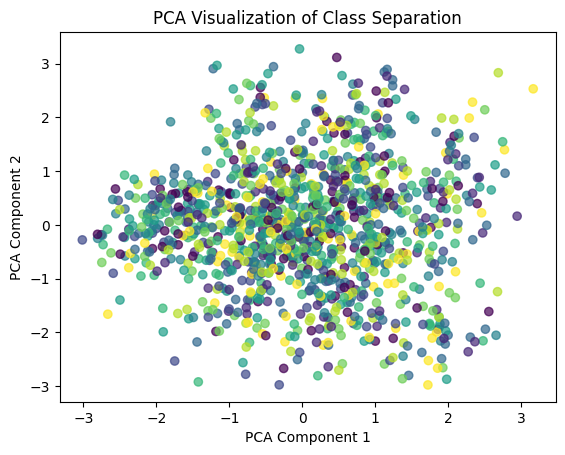

In [19]:
X_encoded = df_encoded.drop(columns=['Panic_Score'])
y_encoded = df_encoded['Panic_Score']
X_scaled = StandardScaler().fit_transform(X_encoded)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap='viridis',alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Class Separation")
plt.show()

The above is Principal Component Analysis (PCA) of the first 2 components of the data before manually encoding occurred. It shows that the data is not as relevant or complex as it should be in order to be able to make predictions on the data. THE WAY TO HANDLE THIS WOULD BE TO COLLECT MORE DETAILED DATA. This would mean adding more features that could have added effect on the label, and/or more detailed categories in already present categorical features.

## 3. Insights from Data <a class="anchor" id="chapter3"></a>